In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPR
import Options
import BlackScholes as BS
import ImpliedVolatility as IV
import Probability_Utils as Prob

TICKER = 'SPY'

In [2]:
ExpiryDates = yf.Ticker(TICKER).options
print(ExpiryDates)
DateN = 12
options = yf.Ticker(TICKER).option_chain(ExpiryDates[DateN])
Calls = options.calls
Puts = options.puts
current_price = yf.Ticker(TICKER).history(period='1d')['Close'][0]
K = Calls['strike']
k = np.log(Calls['strike'] / current_price)


('2025-10-08', '2025-10-09', '2025-10-10', '2025-10-13', '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-14', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-01-30', '2026-02-20', '2026-02-27', '2026-03-20', '2026-03-31', '2026-06-18', '2026-06-30', '2026-09-18', '2026-09-30', '2026-12-18', '2027-01-15', '2027-12-17', '2028-01-21')


C:\Users\adamd\AppData\Local\Temp\ipykernel_33036\748746406.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = yf.Ticker(TICKER).history(period='1d')['Close'][0]


Current Price: 672.6199951171875, Forward Price: 675.8305856712391
Minimum IV at k=0.05494053061765224, K = 714.0, IV = 0.11346880477637153
Using 112 valid points for fitting.
Loss: 0.0001266087987522261
Initial guess: v=0.001533, psi=0.500000, chi=0.000000, p=0.054941, zeta=0.100000
Fitted SVI-JW parameters: v=0.001000, psi=0.050522, chi=-0.493465, p=0.025529, zeta=0.025802
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-4.826e-06  1.700e-05 ...  5.631e-04  7.337e-04]
           x: [ 1.000e-03  5.052e-02 -4.935e-01  2.553e-02  2.580e-02]
        cost: 1.9379744979396815e-06
         jac: [[-2.414e-03 -7.016e-04 ... -9.092e-05 -4.038e-06]
               [-3.395e-03 -9.603e-04 ... -1.279e-04 -5.839e-06]
               ...
               [-1.422e+00 -5.102e-02 ...  1.758e-02 -6.656e-03]
               [-1.347e+00 -5.040e-02 ...  1.670e-02 -6.038e-03]]
        grad: [ 3.106e-03 -8.642e-13 -5.687e-11 -3.066e-09 -3.305e-10]
  optim

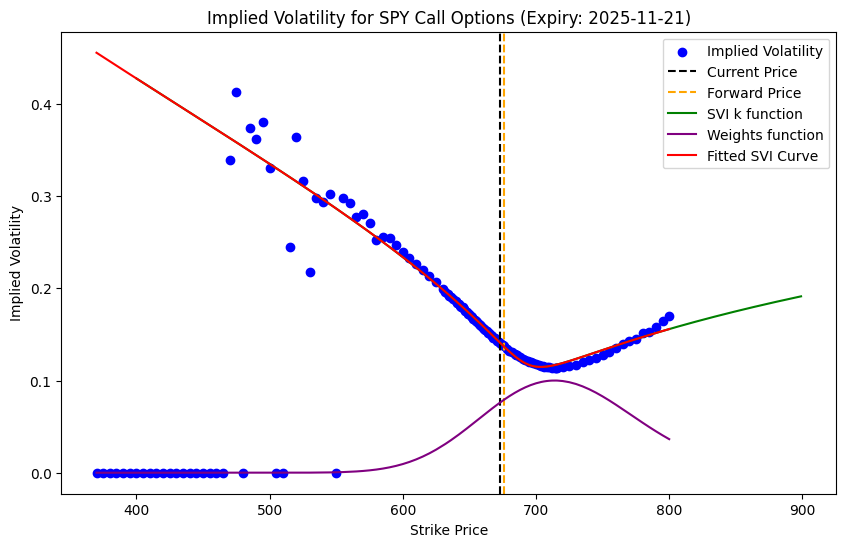

In [ ]:
CallOptions = pd.DataFrame({
    'Strike': Calls['strike'],
    'bid': Calls['bid'],
    'ask': Calls['ask'],
    'Price': np.where(
        (Calls['bid'] == 0) | (Calls['ask'] == 0),
        Calls['lastPrice'],
        (Calls['bid'] + Calls['ask']) / 2
    ),
    'Type': 'C',
    'Expiry': pd.to_datetime(ExpiryDates[DateN]),
    'Spot': current_price,
    'Rate': 0.04
})
ForwardPrice = current_price * np.exp(CallOptions['Rate'].iloc[0] * (Options.trading_days_between(pd.Timestamp.today(), CallOptions['Expiry'].iloc[0]) / 252))
print(f"Current Price: {current_price}, Forward Price: {ForwardPrice}")
CallOptions['Implied Volatility'] = IV.BS_Implied_Volatility(CallOptions)
K = np.arange(400, 900, 1)

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['Implied Volatility'], color='blue', label='Implied Volatility')
plt.axvline(x=current_price, color='black', linestyle='--', label='Current Price')
plt.axvline(x=ForwardPrice, color='orange', linestyle='--', label='Forward Price')
plt.title(f'Implied Volatility for {TICKER} Call Options (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

# fit to SVI curve
result, svi_curve, svi_k, w = IV.fit_IV_slice(CallOptions)
plt.plot(K, svi_k(K), color='green', label='SVI k function')
plt.plot(CallOptions['Strike'], w/np.max(w)/10, color='purple', label='Weights function')
plt.plot(CallOptions['Strike'], svi_curve, color='red', label='Fitted SVI Curve')
plt.legend()
plt.show()



Area: 0.001755590267128074, Mean: 656.91221417986, StdDev: 50.88821170035074, Skew: -0.9948941643733065, Kurtosis: 4.8473420319279255


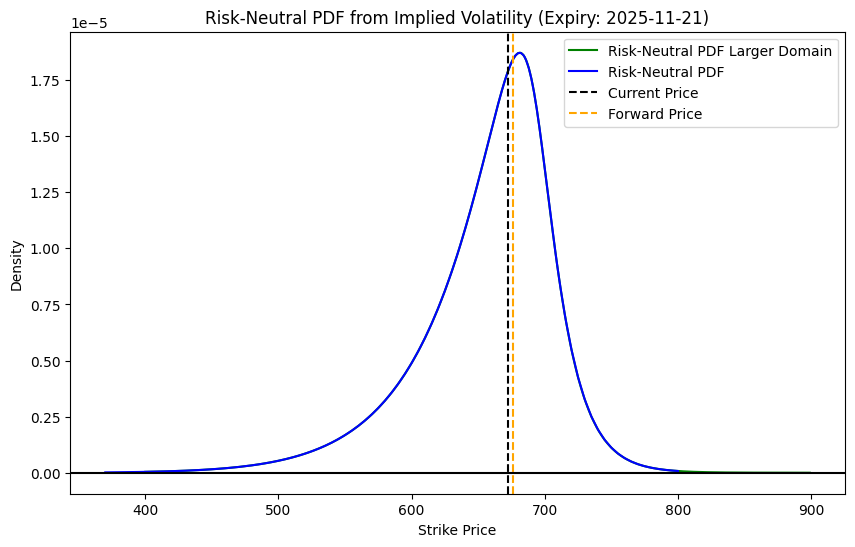

In [ ]:
P, P_k = IV.Distribution_from_IV(CallOptions, svi_curve, svi_k)

Area, mu, stddev, skew, kurt = Prob.moments(K, P_k(K))
print(f"Area: {Area}, Mean: {mu}, StdDev: {stddev}, Skew: {skew}, Kurtosis: {kurt}")

plt.figure(figsize=(10, 6))
plt.plot(K, P_k(K), color='green', label='Risk-Neutral PDF Larger Domain')
plt.plot(CallOptions['Strike'], P, color='blue', label='Risk-Neutral PDF')
plt.axvline(x=current_price, color='black', linestyle='--', label='Current Price')
plt.axvline(x=ForwardPrice, color='orange', linestyle='--', label='Forward Price')
plt.axhline(y=0, color='black', linestyle='-')
plt.title(f'Risk-Neutral PDF from Implied Volatility (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Density')
plt.legend()
plt.show()

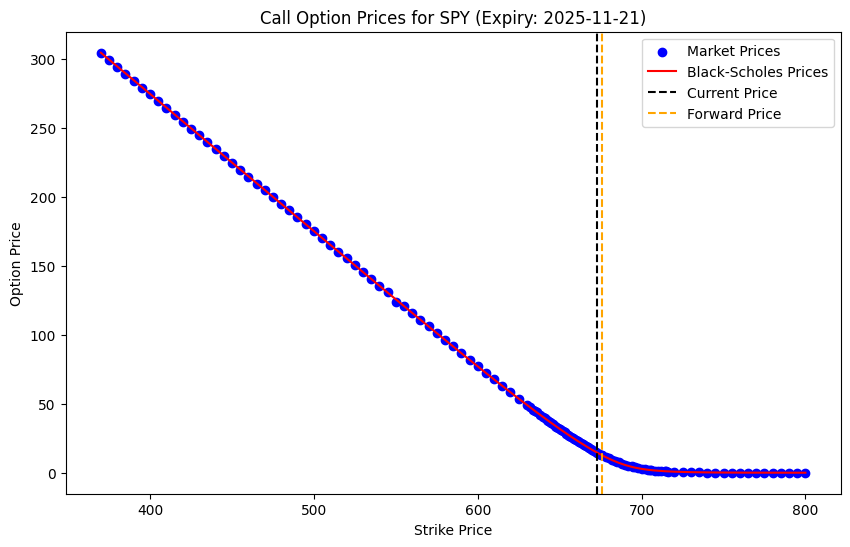

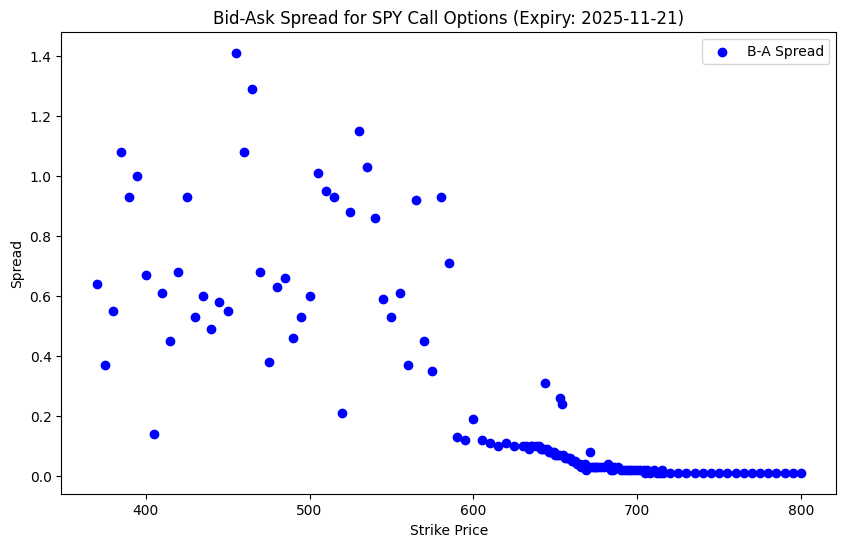

In [ ]:
BS_Call_Prices = BS.BS_Option_Price(CallOptions, svi_curve)

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['Price'], color='blue', label='Market Prices')
plt.plot(CallOptions['Strike'], BS_Call_Prices, color='red', label='Black-Scholes Prices')
plt.axvline(x=current_price, color='black', linestyle='--', label='Current Price')
plt.axvline(x=ForwardPrice, color='orange', linestyle='--', label='Forward Price')
plt.title(f'Call Option Prices for {TICKER} (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(CallOptions['Strike'], CallOptions['ask']-CallOptions['bid'], color='blue', label='B-A Spread')
plt.title(f'Bid-Ask Spread for {TICKER} Call Options (Expiry: {ExpiryDates[DateN]})')
plt.xlabel('Strike Price')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [6]:

# print(Calls)

# Find Characteristic Function of Underlying Asset Return Distribution
# Phi = -u^2 * int(exp(iuK) * C(K) dK) 
import torch
K = torch.tensor(K.values, dtype=torch.float32)
C = torch.tensor(Calls['lastPrice'].values, dtype=torch.float32)

# interpolate to evenly spaced grid
NPoints = 2**10
K = torch.linspace(650, 700, NPoints)
from scipy.interpolate import interp1d
C = interp1d(Calls['strike'], Calls['lastPrice'], bounds_error=False, fill_value="extrapolate")(K)
C = torch.tensor(C, dtype=torch.float32)
dK = K[1] - K[0]

du = 2 * np.pi / (NPoints * dK)
u = torch.fft.fftshift(torch.fft.fftfreq(NPoints, d=dK)) * 2 * torch.pi
C_fft = torch.fft.fftshift(torch.fft.fft(torch.fft.ifftshift(C))) * dK
C_kk_rec = torch.fft.fftshift(torch.fft.ifft(torch.fft.ifftshift(- u**2 * C_fft))) * NPoints * du / (2 * np.pi)
C_kk_rec = C_kk_rec.real

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(K, C, label='Call Prices C(K)')
plt.title('Data Call Prices C(K)')
plt.xlabel('K')
plt.ylabel('C(K)')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(u, torch.real(C_fft), label='Re(φ(u))')
plt.plot(u, torch.imag(C_fft), label='Im(φ(u))')
plt.title('Fourier Transform φ(u)')
plt.xlabel('u')
plt.ylabel('φ(u)')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(K, C_kk_rec, label='Reconstructed d2C(K)/dK2', linestyle='--')
plt.title('Reconstructed Function d2C(K)/dK2')
plt.xlabel('K')
plt.ylabel('d2C(K)/dK2')
plt.ylim(-10, 10)
plt.legend()
plt.tight_layout()
plt.show()


mu, COV, mu_xx = GPR.fit_option_price(Calls['strike'], Calls['lastPrice'], current_price)
f, h, w = Options.fit_option_price_hermite(Calls['strike'], Calls['lastPrice'], current_price, N = 7, w0=np.array([1, 0, 1, 0, 1, 0, 1]))


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(K, Calls['lastPrice'], color='blue', label='Call Prices')
plt.plot(K, mu, color='red', label='GPR Mean')
plt.plot(K, f, color='green', label='Options Fit')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.legend()
plt.title(f'GPR Fit to {TICKER} Call Option Prices (Expiry: {ExpiryDates[3]})')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(K, mu_xx, color='orange', label='d2mu/dK2')
# mu_xx = np.maximum(mu_xx, 0) / np.abs(np.trapezoid(Calls['strike'].values, np.maximum(mu_xx, 0)))  # Ensure non-negativity & Normalize
# plt.plot(K, mu_xx, color='green', label='Non-negative d2mu/dK2')
plt.plot(K, h**2, color='purple', label='d2F/dK2')
plt.plot(K, h**2 / np.abs(np.trapezoid(K, h**2)), color='red', label='Normalized d2F/dK2')
plt.axvline(x=current_price, color='orange', linestyle='--', label='Current Price')
plt.plot(K, h, color='blue', label='h(K)')
plt.title(f'Second Derivative of Option Price Fit (Expiry: {ExpiryDates[3]})')
plt.xlabel('Strike Price')
plt.ylabel('Second Derivative')
plt.legend()
plt.show()

